# Resume Classifier with Naive Bayes Classifier
<p>According to <b><a href="https://careers.workopolis.com/">Workopolis</a></b>, Employers receive averagely between 75 and 250 applications per job posting. This can make it difficult and stressful to identify qualified candidates. In order to avoid having to read through the entire pile of resumes, most employers use applicant tracking systems (ATS).<br></p>
<p>Applicant tracking system software ranks each applicant based on how well their resume scores based on the job description. In this project, I work with a Dataset to build a model that screens resumes and can be practically used in companies.</p>

In [1]:
#Install Packages if not already installed
#!pip install nltk
#!pip install gensim
#!pip install wordcloud


#Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Import Data

CSV Structure:


|resume_id|class|resume_text|
| :-| :- | :-|
|resume_1|not_flagged|Customer Service Supervisor/Tier -...|
| ... | ... | ... |

**resume_id** -Candidate CV ID <br>
**class** - Target Feature( indicates if the Candidate was invited for an interview or not).<br>
**resume_text** -Resume text content scrapped file each file


In [2]:
# load the data
resume_df=pd.read_csv('../data/resume.csv',encoding='latin-1')
resume_df.head()

,resume_id,class,resume_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...


Now we drop the " **resume_id** " because its not important for our model build.

In [3]:
# data containing resume
resume_df= resume_df[['resume_text','class']]
resume_df.head()

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,not_flagged
1,\rEngineer / Scientist - IBM Microelectronics ...,not_flagged
2,\rLTS Software Engineer Computational Lithogra...,not_flagged
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,not_flagged
4,\rIndependent Consultant - Self-employed\rBurl...,flagged


## Exploratory Data Analysis

Before making assumptions, lets look at data and see if we can identify errors and understand patterns within the data.

In [4]:
# obtain dataframe information
resume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   resume_text  125 non-null    object
 1   class        125 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


In [5]:
# Find Null/Missing Values
resume_df.isnull().sum()

resume_text    0
class          0
dtype: int64

<AxesSubplot:>

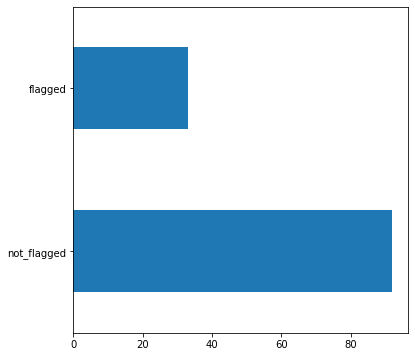

In [6]:
#View distribution
resume_df['class'].value_counts().plot(kind='barh', figsize=(6, 6))

#### Encode the Class Values 
**flagged:** 1 <br>
**not_flagged:** 0

In [7]:
resume_df['class']=resume_df['class'].apply(lambda x:1 if x=='flagged' else 0)
resume_df.head()

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,0
1,\rEngineer / Scientist - IBM Microelectronics ...,0
2,\rLTS Software Engineer Computational Lithogra...,0
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,0
4,\rIndependent Consultant - Self-employed\rBurl...,1


## Data Cleaning

Lets clean our data and try to find incorrect, incomplete, inaccurate, or irrelevant data.

In [8]:
resume_df['resume_text']=resume_df['resume_text'].apply(lambda x: x.replace('\r',''))
resume_df.head()

,resume_text,class
0,Customer Service Supervisor/Tier - Isabella Ca...,0
1,Engineer / Scientist - IBM Microelectronics Di...,0
2,LTS Software Engineer Computational Lithograph...,0
3,TUTORWilliston VT - Email me on Indeed: indee...,0
4,Independent Consultant - Self-employedBurlingt...,1


In [9]:
# download nltk packages
nltk.download('punkt')
# download nltk packages
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/samuel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samuel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Remove Stop Words
Stop words are commonly used words (such as “the”, “a”, “an”, “in”) which need to be filtered out from our natural language data (text) to reduce noise in the data.

In [10]:
# Get additional stopwords from nltk
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use','email'])


In [11]:
# Define function to remove stop words and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return ' '.join(result)

In [12]:
# Cleaned text
resume_df['cleaned']=resume_df['resume_text'].apply(preprocess)
resume_df.head()

,resume_text,class,cleaned
0,Customer Service Supervisor/Tier - Isabella Ca...,0,customer service supervisor tier isabella cata...
1,Engineer / Scientist - IBM Microelectronics Di...,0,engineer scientist ibm com albert gregoritsch ...
2,LTS Software Engineer Computational Lithograph...,0,lts software engineer computational lithograph...
3,TUTORWilliston VT - Email me on Indeed: indee...,0,tutorwilliston com alec schwartz awork college...
4,Independent Consultant - Self-employedBurlingt...,1,independent consultant self com alex reutter f...


## Visualize Cleaned Data

Most Common words in Resume of candidates invited:

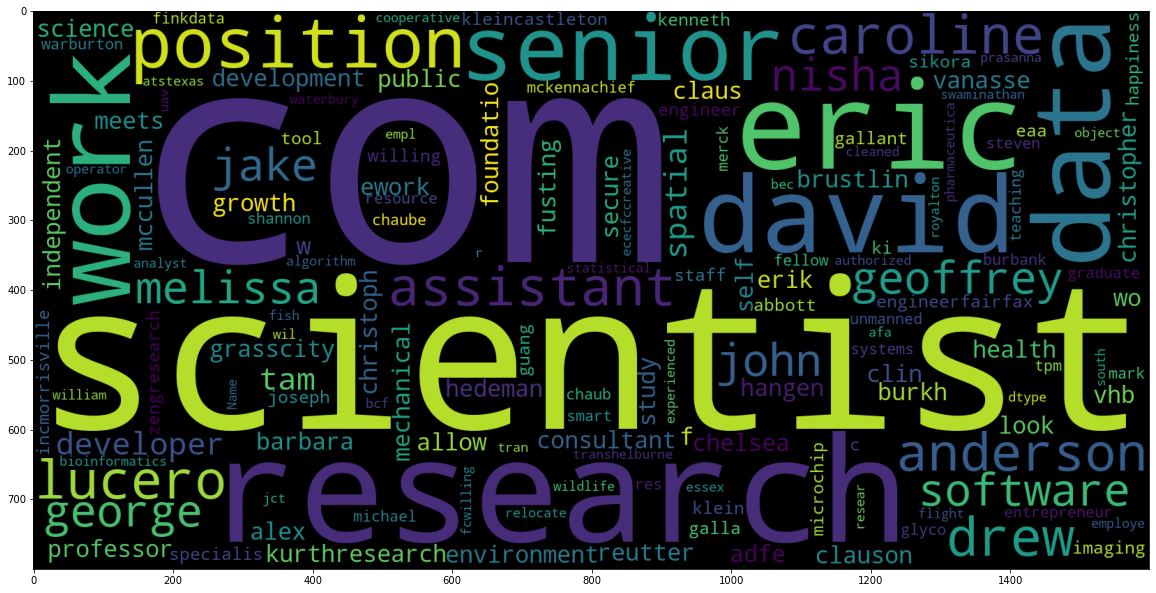

In [13]:
# plot the word cloud for text that is flagged
plt.figure(figsize = (20,20)) 
wc=WordCloud(max_words=2000,width=1600, height=800,stopwords=stop_words).generate(str(resume_df[resume_df['class']==1].cleaned))
plt.imshow(wc)

Common Words in CV of Candidates not invited:

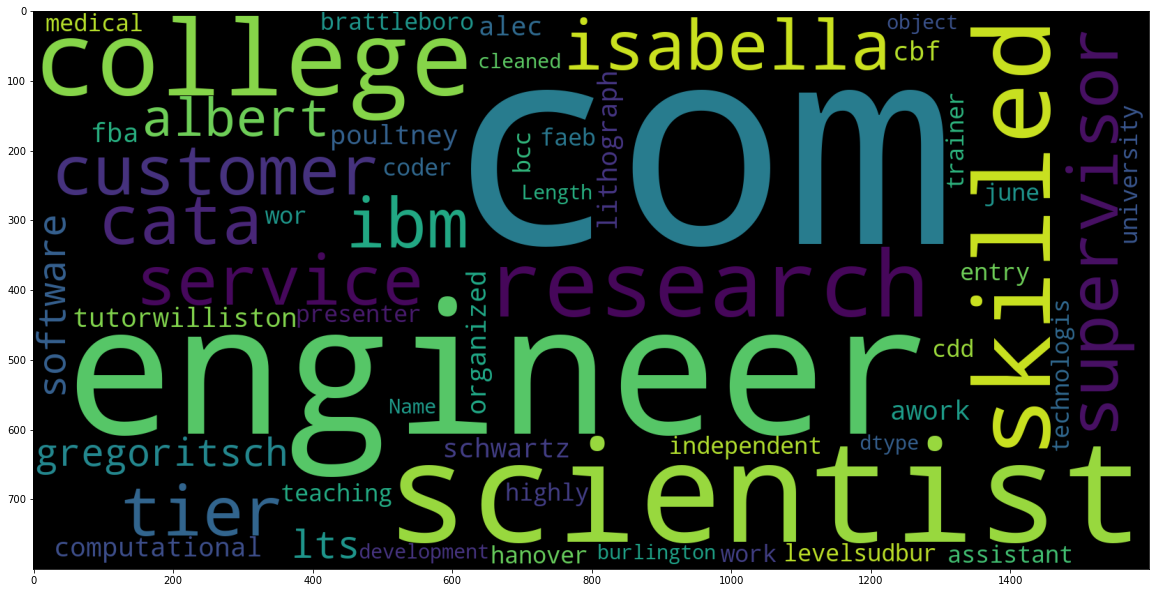

In [14]:
# plot the word cloud for text that is flagged
plt.figure(figsize = (20,20)) 
wc_not=WordCloud(max_words=2000,width=1600, height=800,stopwords=stop_words).generate(str(resume_df[resume_df['class']==0].cleaned))
plt.imshow(wc_not)

## Data Transformation

**Count Vectorizer** will be used to convert the resume texts to a vector of term/token counts. 

In [15]:
# CountVectorizer example
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer()
countvectorizer=vectorizer.fit_transform(resume_df['cleaned'])

vectorizer.get_feature_names()

['aaalac',
 'aabb',
 'aac',
 'aacn',
 'aacr',
 'aacrjournals',
 'aakeroõ_y',
 'aanpcp',
 'aaron',
 'abbott',
 'abdomen',
 'abdominal',
 'abdul',
 'aberdeen',
 'abi',
 'abilities',
 'ability',
 'abiotic',
 'able',
 'abnormal',
 'aboard',
 'abosalem',
 'abraham',
 'abreast',
 'abs',
 'absence',
 'absorbance',
 'abstract',
 'abstracta',
 'abstractdisease',
 'abstracted',
 'abstractin',
 'abstracts',
 'abualrub',
 'abundance',
 'abureehan',
 'abuse',
 'abusiness',
 'academia',
 'academic',
 'academics',
 'academy',
 'acaeefbc',
 'accelerated',
 'accept',
 'acceptability',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'access',
 'accessibility',
 'accessible',
 'accession',
 'accident',
 'accidents',
 'accolateî',
 'accommodations',
 'accomplished',
 'accomplishment',
 'accomplishments',
 'accord',
 'accordance',
 'according',
 'accordingly',
 'accords',
 'account',
 'accountability',
 'accountable',
 'accounted',
 'accounting',
 'accounts',
 'accreditation',
 'accredited',
 'ac

## Train Model

In [16]:
X=countvectorizer
y=resume_df['class']

Split Testing and Training data

In [17]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test=train_test_split(X,y,test_size=0.3)

Import and build model

In [18]:
from sklearn.naive_bayes import MultinomialNB

NB_clf=MultinomialNB()
NB_clf.fit(X_train,y_train)

MultinomialNB()

## Evaluating Model Performance using Confusion Matrix

**A Confusion Matrix** is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.

Here are some basic definitions needed to understand the CM Table:

1. True Positives (TP): These are cases in which we predicted yes (they have the disease), and they do have the disease.
2. True Negatives (TN): We predicted no, and they don't have the disease.
3. False Positives (FP): We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
4. False Negatives (FN): We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

![Confusion Matrrix](https://www.researchgate.net/profile/Bin-Xia-13/publication/283330762/figure/fig3/AS:619254843985928@1524653268934/The-confusion-matrix-and-relevant-evaluation-index-True-Positive-TP-The-number-of.png)


<AxesSubplot:>

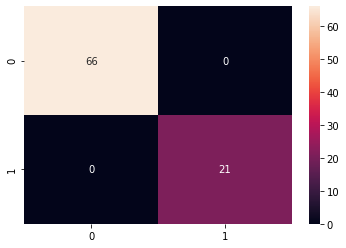

In [19]:
# Predicting the performance on train data
y_predict_train = NB_clf.predict(X_train)
y_predict_train
cm = confusion_matrix(y_train, y_predict_train)
sns.heatmap(cm, annot = True)

<AxesSubplot:>

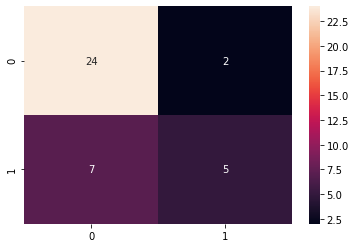

In [20]:
# Predicting the Test set results
y_predict_test = NB_clf.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot = True)

In [21]:
# classification report
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           1       0.71      0.42      0.53        12

    accuracy                           0.76        38
   macro avg       0.74      0.67      0.68        38
weighted avg       0.76      0.76      0.74        38

